# Demo: RLPF Simulation for Ad Text

This notebook demonstrates a small RLPF-style workflow using either real Ad Library data or synthetic fallback.

**Data source link (not included in the repo):**
- Ad Library API docs: https://developers.facebook.com/docs/marketing-api/reference/ads_archive/

If you have real data, save it as `demo/ads_real.csv` and make sure it contains a text field such as `ad_creative_body`.


In [2]:
import os
import sys

ROOT = os.path.abspath('..')
if ROOT not in sys.path:
    sys.path.insert(0, ROOT)


In [3]:
import pandas as pd

from src.synthetic_data import generate_synthetic_ads
from src.reward_model import train_reward_model
from src.rlpf_sim import simulate_rlpf

DATA_PATH = 'ads_real.csv'
if os.path.exists(DATA_PATH):
    df = pd.read_csv(DATA_PATH)
else:
    df = pd.DataFrame(generate_synthetic_ads(n=300, seed=42))

df.head()

,ad_id,page_name,ad_creative_body,impressions,clicks,ctr,topic,style
0,syn_00000,Online Shopping Page,Make online shopping easier today. Save time. ...,33004,497,0.015059,online shopping,short and direct
1,syn_00001,Personal Finance App Page,Last week I needed help with personal finance ...,22392,352,0.015720,personal finance app,storytelling
2,syn_00002,Health And Wellness Page,The fast way to handle health and wellness. Sa...,26050,464,0.017812,health and wellness,short and direct
3,syn_00003,Online Shopping Page,A few simple steps to improve online shopping....,7103,149,0.020977,online shopping,advice
4,syn_00004,Books And Learning Page,Make books and learning easier today. Improve ...,44484,795,0.017872,books and learning,short and direct


In [4]:
df['text'] = df.get('ad_creative_body', df.get('text', '')).fillna('')
df = df[df['text'].str.strip().astype(bool)]

df['score'] = df.get('ctr', 0).fillna(0)
reward_model = train_reward_model(df['text'], df['score'])
results = simulate_rlpf(df['text'].tolist()[:50], reward_model, n_variations=5)
results[:3]

[{'original_text': 'Make online shopping easier today. Save time. See details.',
  'original_score': 0.014908722354270383,
  'best_text': 'Make online shopping easier today. Save time.',
  'best_score': 0.015201539479547,
  'delta': 0.00029281712527661624,
  'all_scores': [0.014908722354270383,
   0.014908722354270383,
   0.014908722354270383,
   0.014652703023247653,
   0.015201539479547,
   0.015201539479547],
  'all_texts': ['Make online shopping easier today. Save time. See details.',
   'Make online shopping easier today. Save time. See details?',
   'Make online shopping easier today. Save time. See details?',
   'Make online shopping easier today. Save time. See details . Sign up now.',
   'Make online shopping easier today. Save time.',
   'Make online shopping easier today. Save time.']},
 {'original_text': 'Last week I needed help with personal finance app, and found a better way. See results faster. Sign up now.',
  'original_score': 0.017389178703263505,
  'best_text': 'Las

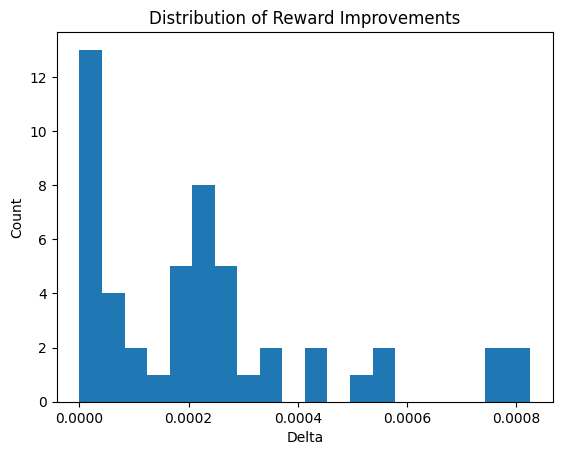

In [5]:
import numpy as np
import matplotlib.pyplot as plt

deltas = np.array([r['delta'] for r in results])
plt.hist(deltas, bins=20)
plt.title('Distribution of Reward Improvements')
plt.xlabel('Delta')
plt.ylabel('Count')
plt.show()